# Minimum code for Figure S4 qPCR panel

## Load libraries

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))

## Read in annotations

In [4]:
annotations <- read_csv("../annotations/sampleannotations.csv") %>% 
  print()

Rows: 12 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Amplicon, Reporter
dbl (1): Well

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 12 × 3
    Well Amplicon Reporter
   <dbl> <chr>    <chr>   
 1    16 mCherry  PTC     
 2    17 mCherry  NTC     
 3    28 mCherry  PTC     
 4    29 mCherry  NTC     
 5    40 mCherry  PTC     
 6    41 mCherry  NTC     
 7    52 B-globin PTC     
 8    53 B-globin NTC     
 9    64 B-globin PTC     
10    65 B-globin NTC     
11    76 B-globin PTC     
12    77 B-globin NTC     


## Read in Ct data; join with annotations

In [11]:
ct_data <- read_csv("../../../../data/qpcr/nmd_reporter_validation/ct_values.csv", skip = 47, col_types = cols(CT = col_double())) %>% 
   select(CT, Well) %>%
   inner_join(annotations) %>%
   select(-Well) %>%
   print()

Warning message:
“One or more parsing issues, see `problems()` for details”
Joining, by = "Well"


# A tibble: 12 × 3
      CT Amplicon Reporter
   <dbl> <chr>    <chr>   
 1  25.6 mCherry  PTC     
 2  25.3 mCherry  NTC     
 3  25.5 mCherry  PTC     
 4  25.5 mCherry  NTC     
 5  25.6 mCherry  PTC     
 6  25.5 mCherry  NTC     
 7  24.8 B-globin PTC     
 8  19.2 B-globin NTC     
 9  24.7 B-globin PTC     
10  19.1 B-globin NTC     
11  24.5 B-globin PTC     
12  19.0 B-globin NTC     


## Plot raw CT values 

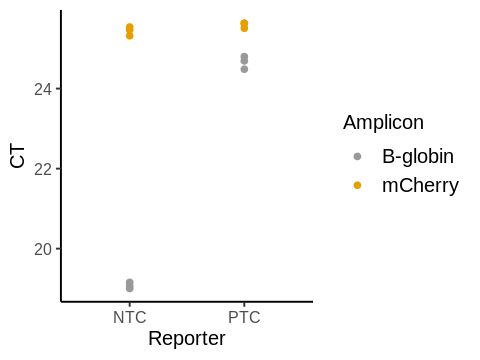

In [13]:
options(repr.plot.width=4, repr.plot.height=3)

ct_data %>% 
  ggplot(aes(x = Reporter, y = CT, color = Amplicon)) +
  geom_point() +
  scale_color_manual(values = cbPalette) +
  # theme(axis.text.x = element_text(angle = 45, hjust = 1))
  NULL 

ggsave("../figures/bglobin_ct_values.pdf", height = 3, width = 4) 

## Normalize YFP expression to mCherry

In [14]:
norm_yfp <- ct_data  %>%
  group_by(Amplicon, Reporter) %>%
  summarize(std_error = sd(CT),
            CT = mean(CT)) %>%
  ungroup() %>%
  mutate(mcherry_norm_ct = CT - CT[Amplicon == "mCherry"],
         mcherry_norm_error = sqrt(std_error^2 + std_error[Amplicon == "mCherry"]^2)) %>%
  print()

`summarise()` has grouped output by 'Amplicon'. You can override using the `.groups` argument.


# A tibble: 4 × 6
  Amplicon Reporter std_error    CT mcherry_norm_ct mcherry_norm_error
  <chr>    <chr>        <dbl> <dbl>           <dbl>              <dbl>
1 B-globin NTC         0.0774  19.1          -6.36               0.136
2 B-globin PTC         0.160   24.7          -0.933              0.175
3 mCherry  NTC         0.112   25.4           0                  0.158
4 mCherry  PTC         0.0719  25.6           0                  0.102


## Plot normalized YFP expression

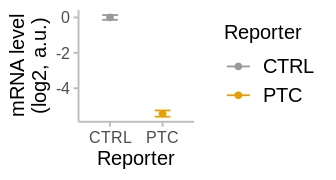

In [15]:
options(repr.plot.width=2.8, repr.plot.height=1.5)

norm_yfp %>% 
  filter(Amplicon == "B-globin") %>%
  mutate(Reporter = if_else(Reporter == "NTC", "CTRL", Reporter)) %>% 
  mutate(mcherry_norm_ct = - mcherry_norm_ct + min(mcherry_norm_ct)) %>%
  ggplot(aes(x = Reporter, y = mcherry_norm_ct, ymax = mcherry_norm_ct + mcherry_norm_error, ymin = mcherry_norm_ct - mcherry_norm_error)) +
  geom_point(aes(color = Reporter)) +
  geom_errorbar(width = 0.3, aes(color = Reporter)) +
  # theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_color_manual(values = cbPalette) +
  theme(axis.line = element_line(color = "grey"), axis.ticks = element_line(color = "grey")) +
  labs(x = "Reporter", y = "mRNA level\n(log2, a.u.)")


ggsave("../figures/bglobin_normalized_yfp_ct_values_inverted.pdf", height = 1.5, width = 2.8) 